# **Name:** MIN Chen TAN Xinrui

**EID:** 53545230 53543259

**Competition Name:**  Allstate Claims Severity

**Team Name:** Hey Ha

# CS4487 - Course Project

Due date: Nov 25, 11:59pm

## Goal
You can select your course project as _one_ of the following competitions:

### 1. [Allstate Claims Severity](https://www.kaggle.com/c/allstate-claims-severity): predict the cost of claims
(This is hosted on Kaggle)

> When you’ve been devastated by a serious car accident, your focus is on the things that matter the most: family, friends, and other loved ones. Pushing paper with your insurance agent is the last place you want your time or mental energy spent. This is why Allstate, a personal insurer in the United States, is continually seeking fresh ideas to improve their claims service for the over 16 million households they protect.

> Allstate is currently developing automated methods of predicting the cost, and hence severity, of claims. In this recruitment challenge, Kagglers are invited to show off their creativity and flex their technical chops by creating an algorithm which accurately predicts claims severity. Aspiring competitors will demonstrate insight into better ways to predict claims severity for the chance to be part of Allstate’s efforts to ensure a worry-free customer experience.

### 2. [Alphabase](http://www.alphabase.ai): predict the investment outcome
(This is hosted on Alphabase.ai)

> Traditionally, investors have performed long-term fundamental analysis by studying the income statements, balance sheets, and other publicly available information about a company’s operations. Then, they use this information in the context of the company’s market value to make an informed decision about its prospects as a long-term investment.

> The automation of this process, systematic value investing, has become possible with the emergence of high-quality data on company fundamentals and the ever-increasing computational power available to researchers. Machine learning becomes an efficient tool in the process of systematic value investing by employing a learning algorithm which programmatically searches for methods of selecting, weighting, and transforming a company’s financial data that (in the context of its current price) best predict how the company will perform as an investment.

> The prediction task is based on framework described above. You will be provided with two separate datasets. Use the training data to train your machine learning algorithm. In total, there are 55 features (companies’ financial data) in our datasets. For each feature, however, three different methods are used to process the data, and then get 165 feature columns in the datasets. Target in the last column is the binary class you're trying to predict (investment outcome).

## Groups
Group projects with at most 2 students are allowed.  To sign up for a group, go to Canvas and under "People", join one of the existing "Project Groups".  _For group projects, the project report must state the percentage contribution from each project member._

## Methodology
You are free to choose the methodology to solve the task.  In machine learning, it is important to use domain knowledge to help solve the problem.  Hence, instead of blindly applying the algorithms to the data you need to think about how to represent the data in a way that makes sense for the algorithm to solve the task. 


## Evaluation on Kaggle/Alphabase

Besides evaluating on the validation set, you need to submit your test results to Kaggle or Alphabase for evaluation.

## Project Presentation

Each project group needs to give a presentation at the end of the semester.  The presentation time is 8 minutes.  You _must_ give a presentation.

## What to hand in
You need to turn in the following things:

1. This ipynb file with your source code and documentation.
2. Your final submission file to Kaggle/Alphabase.
3. Presentation slides.

Files should be uploaded to "Course Project" on Canvas.


## Grading
The marks of the assignment are distributed as follows:
- 50% - Results using various feature representations, dimensionality reduction methods, classifiers, etc.
- 20% - Trying out feature representations (e.g. adding additional features, combining features from different sources) or methods not used in the tutorials.
- 15% - Quality of the written report.  More points for insightful observations and analysis.
- 15% - Project presentation.
<hr>

# Contribution
In our group, we have equal percentage of contribution.

# 1. Introduction

Kaggle, as a very popular platform for predictive modelling, provides a lot of analytics competitions. In this poroject, we attended the competition Allstate Claims Severity in Kaggle to predict the cost of claims. We interpreted this problem as a regression problem, since the target values are very likely to be continous. So we aimed to train a model that can predict the targets accurately.

To achieve our goal, we wanted to train a model that can combine the advantages of several different algorithms and decided to do this by assigning optimal weights to those algorigthms such that the linearly combined regressor can have the best performance. 

Since there are string values in many attributes in the dataset, we would first convert those values to numeric. We adopted two methods here to preprocess the data: one is the "one-hot" encoding given in the helper code, another is an isotropic representation, which converts the values to coordinates of vertices of simplexes in $\mathbb{R^n}, n \in \mathbb{N}$. 

For the preprocessed data obtained through each method, we performed prior trails to test whether it would be proper to be used for training models directly. However, due to the high dimensionality, the dataset was usually not suitable and thus dimensionality reduction was required. After the dimension of data was reduced, we split the given training dataset into training set and validation set so that training set can be kept for future use of determinig weights. 

We then trained both linear and non-linear models, including Ridge Regression, Elastic Network, linear Robust Regression, linear SVR, and kernel based SVR models. The reasons for selection of these models will be illustrated in subsequent sections.

For the determination of weights, we would find the weight values that minimize the resulted MAE on the validation set, so it is equivalent to solve an optimization problem.

Finally, the results would be discussed and sumarized in the last section. 


# 2. Initialization and Preprocessing

First we initialze Python and set up some useful functions for loading data and wrting files with the help from the helper code.

In [2]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
import IPython.utils.warn as warn
random.seed(100)
import json
import csv

C:\Users\User\Anaconda2\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Users\User\Anaconda2\lib\site-packages\sklearn\qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


In [3]:
def load_allstate(fname):
    head = []
    dataID = []
    dataX  = []
    dataY  = []
    catmask = []
    with open(fname, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        trainingset = False
        for row in reader:
            if len(head) == 0:
                head = row
                if head[-1] == "loss":
                    trainingset = True
                    featnames = head[1:-1]
                else:
                    trainingset = False
                    featnames = head[1:]
                catmask = map(lambda x: x.startswith("cat"), featnames)
                
            else:             
                # process the list into an array
                dataID.append(int(row[0]))
                if trainingset:
                    dataY.append(float(row[-1]))
                    tmpX = row[1:-1]
                else:
                    tmpX = row[1:]
                    
                # process data
                for i,v in enumerate(tmpX):
                    # for categorical features, convert string code (e.g "BA") into integer
                    if catmask[i]:
                        if not v.isalpha():
                            print "bad cat: " + v
                            return
                        if len(v) == 1:
                            # single letter -> [0,25]
                            catval = ord(v[0]) - ord("A")
                        elif len(v) == 2:
                            # 2 letters -> 26*(v[0]+1) + v[1]
                            catval = 26*(ord(v[0])-ord("A")+1) + (ord(v[1]) - ord("A"))
                        else:
                            print "ERROR"
                            return
                        
                        tmpX[i] = float(catval)
                    else:
                        # for float features, just convert to float
                        tmpX[i] = float(v)    
                dataX.append(tmpX)

    return array(dataX), array(dataY), array(dataID), featnames, catmask

In [4]:
import csv

def write_csv_allstate(fname, YID, Y):
    # fname = file name
    # Y is the prediction
    # YID is the test case ID number
    
    # write CSV file
    f = open(fname, 'w')
    f.write("id,loss\n")

    # add ID numbers for each Y
    for (i,y) in enumerate(Y):
        f.write("%d,%f\n" % (YID[i], y))
        
    f.close()    

Here we load the data and see the shape:

In [5]:
# load the data
trainX, trainY, trainID, featnames, catmask = load_allstate("train.csv")
testX, testY, testID, _, _ = load_allstate("test.csv")

print trainX.shape
print trainY.shape
print testX.shape

(188318L, 130L)
(188318L,)
(125546L, 130L)


In [28]:
print featnames

['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', 'cat111

From the above, it can be observed that the first 116 features are categorical features, while others are likely to be continuous.
For ease of performing vlaue convertion, we convert the categorical feature values to continuous integer values. 

In [5]:
for j in range(trainX.shape[1]):
    if catmask[j]:
        catmap = list(unique(trainX[:,j]))
        print str(j) + ": " + str(len(catmap)) + " : " + str(catmap)
        
        if len(catmap) == max(catmap)+1:
            print "OK"
        else:
            print "remapping"
            for i in range(trainX.shape[0]):
                trainX[i,j] = catmap.index(trainX[i,j])

0: 2 : [0.0, 1.0]
OK
1: 2 : [0.0, 1.0]
OK
2: 2 : [0.0, 1.0]
OK
3: 2 : [0.0, 1.0]
OK
4: 2 : [0.0, 1.0]
OK
5: 2 : [0.0, 1.0]
OK
6: 2 : [0.0, 1.0]
OK
7: 2 : [0.0, 1.0]
OK
8: 2 : [0.0, 1.0]
OK
9: 2 : [0.0, 1.0]
OK
10: 2 : [0.0, 1.0]
OK
11: 2 : [0.0, 1.0]
OK
12: 2 : [0.0, 1.0]
OK
13: 2 : [0.0, 1.0]
OK
14: 2 : [0.0, 1.0]
OK
15: 2 : [0.0, 1.0]
OK
16: 2 : [0.0, 1.0]
OK
17: 2 : [0.0, 1.0]
OK
18: 2 : [0.0, 1.0]
OK
19: 2 : [0.0, 1.0]
OK
20: 2 : [0.0, 1.0]
OK
21: 2 : [0.0, 1.0]
OK
22: 2 : [0.0, 1.0]
OK
23: 2 : [0.0, 1.0]
OK
24: 2 : [0.0, 1.0]
OK
25: 2 : [0.0, 1.0]
OK
26: 2 : [0.0, 1.0]
OK
27: 2 : [0.0, 1.0]
OK
28: 2 : [0.0, 1.0]
OK
29: 2 : [0.0, 1.0]
OK
30: 2 : [0.0, 1.0]
OK
31: 2 : [0.0, 1.0]
OK
32: 2 : [0.0, 1.0]
OK
33: 2 : [0.0, 1.0]
OK
34: 2 : [0.0, 1.0]
OK
35: 2 : [0.0, 1.0]
OK
36: 2 : [0.0, 1.0]
OK
37: 2 : [0.0, 1.0]
OK
38: 2 : [0.0, 1.0]
OK
39: 2 : [0.0, 1.0]
OK
40: 2 : [0.0, 1.0]
OK
41: 2 : [0.0, 1.0]
OK
42: 2 : [0.0, 1.0]
OK
43: 2 : [0.0, 1.0]
OK
44: 2 : [0.0, 1.0]
OK
45: 2 : [0.0, 1.0]
O

Since there are many categorical features in the dataset, where ordinal relationship may not exist, we will further process these feature values after converting them to continous integers.

## (1) Preprocess on features

## a. One-hot Representaion

"One-hot" encoding turns each category feature into a vector. For example, if the category has three values {1,2,3}:
cat 1 -> [1 0 0]
cat 2 -> [0 1 0]
cat 3 -> [0 0 1]

As there are packages for this ready to use, we use it directly to convert the training and test data.

In [29]:
# use one-hot-encoder to transform the categorical features.
ohe = preprocessing.OneHotEncoder(categorical_features=catmask, handle_unknown='ignore')
ohe.fit(trainX)
# transform - these are no sparse matrices
trainXo = ohe.transform(trainX).tocsr()
testXo  = ohe.transform(testX).tocsr()

The new feature space has more dimensions, but is sparse.


In [30]:
print trainX.shape
print trainXo.shape

(188318L, 130L)
(188318, 1153)


## b. Isotropic Representation

For a categorical feature with $k$ values, in this method, a simplex centered at the origin with k vertices in a $(k-1)$-dimensional space will be used to help convert the values to be numerical and the detailed calculations followed the research by Zhang, Liu, Wang, and Zhu (2015) . Let $V$ be a collection of vectors {$V_j ; j = 1, ..., k $} , or alternatively a collection of coordinates of the simplex's vertices,  and define $V_j$ as

$$
V_j = \left\{\begin{align} & (k-1)^{-\frac{1}{2}}\mathbf{1}, \ \ && \text{ if } j = 1 \\
& - \frac{1 + \sqrt{k}}{(k-1)^\frac{3}{2}\mathbf{1}}+ \sqrt{\frac{k}{k-1}}e_{j-1},\ \ && \text{ if } 2 \leq j \leq k, \\
\end{align}\right.$$

where $e_j \in \mathbb{R}^{k-1}$ is a vector of 0's except its $j^th$ element is 1, and $\mathbf{1}\in \mathbb{R}^{k-1}$ is a vector of 1. Then for each ${V_j}$, it has Euclidean norm 1, and the angles between any pair $(W_i, Wj)$ are equal, so the representation is isotropic. Then the original feature values will be first converted to this set of vectors and then split into $k-1$ sub-features, with each sub-feature takes the value of an entry in the vector.

Compared to the "One-hot" representation, the isotropic representation is better in the sence of center point, which is the origin, and it also saves one sub-attribute for conversion of each categorical feature.

Now we implement the procedure by some functions.

First we define `cal_val_number` to get the number of values in each categorical attribute and `cal_new_represent` to calculate the collection of new representations for the values in the attribute. This two functions are helpful for subsequent conversions and can avoid redundent computations of representation for features that take same number of values.

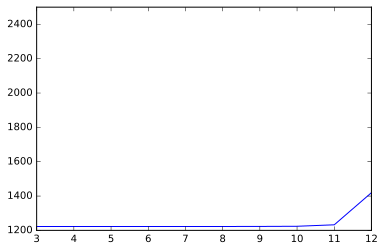

In [542]:
models = [rr, modelen, modelhuber, modelsvr, modelrf, modelpoly, modelrbf]

weights = comp_weight(models, valX, valY,linspace(2,12,11))

In [307]:
# Calculate the number of values in each categorical attribute and return them as a list
def cal_val_number(trainX): 
    temp = transpose(trainX)
    length = []

    for attribute in temp:
        k = len(unique(attribute))     # Get the number of values in this attribute 
        length.append(k)

    return length

# Calculate the collection of new representations for the k values in the attribute 
def cal_new_represent(k):   # k is the number of values in this attribute
    l = array([1] * (k-1))        # l is a vector of 1s with length k-1
    e = identity(k-1)       # identity matrix  
    if k== 1:
        value = [array([0])]
    else:
        temp = pow((k-1),-0.5)*l
        #temp[temp < 0.05] = 0  # set threshhold to force small values be zero
        value = [temp]
        
    for j in arange(1,k,1):
        temp = -((1 + sqrt(k)) / pow((k-1),1.5)) * l + sqrt(k/float(k-1))* e[j-1]
        #temp[temp < 0.05] = 0  # set threshhold to force small values be zero
        value.append(temp)
        
    return value

Below are example results of applying the two functions. They show that: 
    
(1) Same values in an attribute will only be counted once.
    
(2) Representations of a feature with 3 values will be coordinates of a regular triangle  and representations of a feature with 4 values will be coordinates of a tetrahedron. 

In [308]:
# example
S = array([[3,5,6,6],[6,5,36,7],[3,3,3,4,6,5]])
print cal_val_number(S)

k = 3
print cal_new_represent(k)
k = 4
print cal_new_represent(k)

[3, 4, 4]
[array([ 0.70710678,  0.70710678]), array([ 0.25881905, -0.96592583]), array([-0.96592583,  0.25881905])]
[array([ 0.57735027,  0.57735027,  0.57735027]), array([ 0.57735027, -0.57735027, -0.57735027]), array([-0.57735027,  0.57735027, -0.57735027]), array([-0.57735027, -0.57735027,  0.57735027])]


Now we set up the function to fit the training data and convert the test data accordingly. In the function `set_up`, we convert the values in the order of attributes to save computation, insdead of searching and converting all categorical values in one point at a time. This helps us avoid redundant serach for the number of values in those features. In the function `fit_test`, we designed this in a similar style to `model.transform` for some model, and when encountering unexpected values of a feature for some data point, we assign zeros as its sub-feature values.

In [310]:
def set_up(trainX_cat):
    N = cal_val_number(trainX_cat)  # Use N to store the list of the numbers of values in each categorical attribute 
    trainX_cat = transpose(trainX_cat)
    number = len(trainX_cat[0]) # the number of points in the training set
    Diction = []
    cat_number = len(trainX_cat)
    new_trainX_cat = []
    
    # convert the values by each attributes
    for i in arange(cat_number):
        n = N[i] # the number of values in the (i+1)th categorical attribute 
        new_represent = cal_new_represent(n) 
        
        temp = unique(trainX_cat[i])
        
        # set a dictionary to track the value and its position            
        diction = {v:0 for v in temp}
        for j in arange(len(temp)):
            diction[temp[j]] = j  
        Diction.append(diction)
        
        new = [] 
        for j in arange(number):
            v = (trainX_cat[i])[j] 
            newv = new_represent[diction[v]]
            newv = newv.tolist()
            new += newv
            
        New =[]
        for k in arange(n-1):
            New.append([new[(n-1)*j+k] for j in arange(number)])
        new_trainX_cat += New
        
    new_trainX_cat = transpose(array(new_trainX_cat))
    
    return {'new_cat': new_trainX_cat, 'dictionary': Diction, '#values_category': N}
    

In [311]:
def fit_test(testX_cat, fit_result):
    Diction = fit_result['dictionary']
    N = fit_result['#values_category']
    
    testX_cat = transpose(testX_cat)
    number = len(testX_cat[0]) # the number of points in the test set
    
    new_testX_cat = []
    for i in arange(len(N)):
        n = N[i] # the number of values in the (i+1)th categorical attribute 
        new_represent = cal_new_represent(n) 
        
        diction = Diction[i]
            
        new = [] 
        for j in arange(number):
            v = (testX_cat[i])[j] 
            try:
                newv = new_represent[diction[v]]
            except:
                newv = array([0 for k in arange(n-1)])  # Ignore unexpected value by assigning 0
            newv = newv.tolist()
            new += newv
            
        New =[]
        for k in arange(n-1):
            New.append([new[(n-1)*j+k] for j in arange(number)])
        new_testX_cat += New
        
    new_testX_cat = transpose(array(new_testX_cat))
    return new_testX_cat

Here is an example output for the above two functions. The two arrays `h` and `r` represent sets of training data and test data respectively, with every entry representing a data point. We call the functions to fit and transform values in `h` and transform values in `r` accoringly.

In [312]:
# example
h = array([[1,4,3,4,5],[2,2,4,5,7],[4,2,5,6,1],[3,2,5,6,1]])
r = set_up(h)
print r['new_cat']
print "  "
t = array([[1,4,3,4,5],[2,2,4,5,7],[4,2,5,6,1]])
R = fit_test(t, r)
print R

[[ 0.57735027  0.57735027  0.57735027 -1.          0.70710678  0.70710678
   0.70710678  0.70710678  0.25881905 -0.96592583]
 [ 0.57735027 -0.57735027 -0.57735027  1.          0.25881905 -0.96592583
   0.25881905 -0.96592583 -0.96592583  0.25881905]
 [-0.57735027 -0.57735027  0.57735027  1.         -0.96592583  0.25881905
  -0.96592583  0.25881905  0.70710678  0.70710678]
 [-0.57735027  0.57735027 -0.57735027  1.         -0.96592583  0.25881905
  -0.96592583  0.25881905  0.70710678  0.70710678]]
  
[[ 0.57735027  0.57735027  0.57735027 -1.          0.70710678  0.70710678
   0.70710678  0.70710678  0.25881905 -0.96592583]
 [ 0.57735027 -0.57735027 -0.57735027  1.          0.25881905 -0.96592583
   0.25881905 -0.96592583 -0.96592583  0.25881905]
 [-0.57735027 -0.57735027  0.57735027  1.         -0.96592583  0.25881905
  -0.96592583  0.25881905  0.70710678  0.70710678]]


Note that, since the two functions are only written for the categoriacal features, before calling them, we need to seperate out the categorical features. By previous observation, as the first 116 features are categorical, we take them out by specifying range of indices. Then we transform these categorical features and combine the resulted new features with the continous valued features.

In [314]:
temp_train = transpose(trainX)
temp_test = transpose(testX)
trainX_cat = transpose(temp_train[0:116])
trainX_cont = transpose(temp_train[116:])
testX_cat = transpose(temp_test[0:116])
testX_cont = transpose(temp_test[116:])

r = set_up(trainX_cat) # result by the set_up function, containing the transformed result and parameter needed in the function fit_test.
trainX_cat = r['new_cat']
testX_cat = fit_test(testX_cat, r)

trainXn = concatenate((trainX_cat,trainX_cont),axis=1)
testXn = concatenate((testX_cat,testX_cont),axis=1)

In [8]:
print trainXn.shape
print testXn.shape

(188318L, 1037L)
(125546L, 1037L)


Now we have the new training and test data that have 1037 features.

The following three cells are for storing current work.

In [6]:
from sklearn.externals import joblib 

In [368]:
# store the current job
joblib.dump(trainXn, 'trainXn.pkl') 
joblib.dump(testXn, 'testXn.pkl') 

['testXn.pkl', 'testXn.pkl_01.npy']

In [7]:
trainXn = joblib.load('trainXn.pkl') 
testXn = joblib.load('testXn.pkl') 

## (2) Preprocess on target attribute

Since the output targets are real numbers, which are highly imbalanced. We can use the log as the training values.


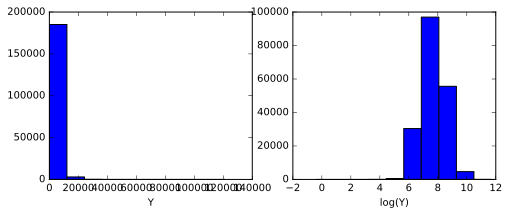

In [31]:
trainYlog = log(trainY)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(trainY)
plt.xlabel('Y')
plt.subplot(1,2,2)
plt.hist(trainYlog);
plt.xlabel('log(Y)');

# 3. Model training

Then we seperate our experiments to two parts:

1. Experiments on the data converted by "One-hot" representaion
2. Experiments on the data converted by isotropic representation

## a."One-hot" representaion

### 1. Prior trails

### (1) Ordinary Least Squares (OLS)

After the feature transfer, the simplest linear regression -- OLS, which mainly aims to minimize the mean square error is trained using all the transferred training data first to see the result.

In [33]:
ols = linear_model.LinearRegression()
ols.fit(trainXo, trainYlog)

trainYlogpred = ols.predict(trainXo)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYlog, trainYlogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainY, trainYpred)

print "MAE_log = " + str(MAElog)
print "MAE = " + str(MAE)

MAE_log = 0.438422939466
MAE = 1238.19754483


In [34]:
# predict on test set, and save Kaggle submission file
testYlogpred = ols.predict(testXo)
testYpred = exp(testYlogpred)
write_csv_allstate("allstate_ols.csv", testID, testYpred)

# Kaggle result: 1816.45239

We can see that the train error is not very large, which is 1238 but after submitting on Kaggle, the test error becomes 1816.45239, which is really large and indicates that there may exist serious overfitting by using all the trainning data. This may because on one hand, OLS is very sensitive to outliers and noise, and therefore very easily to be overfitting. On the other hand, train the model with all the data with all 1153 dimensions may easily cause overfitting since there are at least 1153 coefficients to determine in regression.

Therefore, next we will think of two directions, one is change regression method, another is to consider dimensionality reduction to improve the result.

Here is the code to save the model we trained, in case we need to use it again and do not need to train it again.

In [ ]:
from sklearn.externals import joblib
joblib.dump(ols, 'ols.pkl') 

In [ ]:
ols = joblib.load('ols.pkl') 

### (2) Ridge Regression (RR)

We train RR with all training data to see the result since as mentioned before, OLS is easily to be overfitting and RR adds regularization term to OLS and shrinkages some weight to be zero, which could reduce the overfitting.

In [35]:
# train RR with cross-validation
# alpha values to try
alphas = logspace(-3,6,50)

rr = linear_model.RidgeCV(alphas=alphas, cv=5)
rr.fit(trainXo, trainYlog)

trainYlogpred = rr.predict(trainXo)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYlog, trainYlogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainY, trainYpred)

print "MAE_log = " + str(MAElog)
print "MAE = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYlogpred = rr.predict(testXo)
testYpred = exp(testYlogpred)
write_csv_allstate("allstate_rr.csv", testID, testYpred)

MAE_log = 0.439006778496
MAE = 1241.43802402


In [36]:
print rr.alpha_

25.595479227


From the result we can see, the training error is relatively small, only 1241. After submission, the test error is 1326.72382, which is greatly reduced comparing with that of OLS, but may still exist a bit overfitting.

Therefore, we consider to use dimensionality reduction, not only because it may reduce the overfitting problem, but also because it greatly reduces the running speed, which appear to be necessary later since using training data will full dimensions is very time consuming. For example, the time to train SVR with full dimension data is at least two hours by practice.

In [ ]:
from sklearn.externals import joblib
joblib.dump(rr, 'rr.pkl')

In [ ]:
rr = joblib.load('rr.pkl') 

### 2. Dimensionality reduction with Sparse Random Projection (SRP)

We use SRP to reduce dimension and the reason to use this method is that first and the most important, it is the fastest reduction method; second, it preserves the data struction to ensure the reliability. Consider of the running speed, we finally use this method since other methods like PCA or even non-linear kernel PCA are too slow, which are not practical enough for the large data set. Although SRP will loss some accuracy as a cost to speed up, in this case with large data set, the loss may be not significant.

Here we run a for loop of SRP for different ϵ and verify results by training OLS to find the best ϵ error bound to minimize the MAE of training data. We only need to find the relationship between ϵ and MAE, therefore, use the fastest OLS to train.

Here n_components is set to be 'auto' because it can be automatically adjusted according to the size of training set and the ϵ bound.

In [37]:
# run Sparse Random Projection

score = []
Eps = (arange(0.05, 1, 0.05)).tolist()
length = len(Eps)
i = 0
while i < length-1:  
    try:
        srp = random_projection.SparseRandomProjection(n_components='auto', eps = Eps[i], dense_output=True,random_state=4487)
        trainXnsrp = srp.fit_transform(trainXo) 
        testXnsrp = srp.transform(testXo)

        trainYlog = log(trainY)

        ols = linear_model.LinearRegression(normalize=True)
        ols.fit(trainXnsrp, trainYlog)

        trainYlogpred = ols.predict(trainXnsrp)
        trainYpred = exp(trainYlogpred)

        # calculate MAE in original space
        MAE = metrics.mean_absolute_error(trainY, trainYpred)
        score.append(MAE)
                
    except ValueError:
        print "Oops! ",Eps[i], "is not a proper value for eps" 
        Eps.remove(Eps[i])
        i -= 1
    except IndexError:
        break
    i += 1
        
score = array(score)
plt.plot(Eps, score)

Oops!  0.05 is not a proper value for eps
Oops!  0.1 is not a proper value for eps
Oops!  0.15 is not a proper value for eps
Oops!  0.2 is not a proper value for eps
Oops!  0.25 is not a proper value for eps
Oops!  0.3 is not a proper value for eps


Since smaller ϵ lead to (better embedding and) higher number of dimensions (`n_components`) in the target projection space and we want to speed up with certain acceptable loss, so the chosen ϵ cannot be too small. According to the graph shows above, we choose ϵ = 0.8 since it is at the end of a smooth slope which means small increase of MAE. To fit for the final weight combination step, we split the training data to get a validation set to compute the best weight. Therefore, after dimension reduction, we split the training set into half to half.

In [38]:
a =1srp = random_projection.SparseRandomProjection(n_components='auto', eps = 0.8, dense_output=True,random_state=4487)
trainXnsrp = srp.fit_transform(trainXo) 
testXnsrp = srp.transform(testXo)
trainXI = trainXnsrp
testXI = testXnsrp

#randomly split data into 50% train and 50% validation test
trainXs, valX, trainYs, valY = cross_validation.train_test_split(trainXI, trainY, train_size=0.5, test_size=0.5, random_state=4487)

In [39]:
trainYslog = log(trainYs)
valYlog = log(valY)

In [40]:
print trainXs.shape
print valX.shape

(94159L, 325L)
(94159L, 325L)


### 3.Train Models to be Combined

We train RR, ElasticNet (EN), SGDRegressor with huber loss representing robust regression, SGD with epsilon_insensitive loss function representing linear Support Vector Regression, Polynomial kernel SVR and RBF kernel SVR respectively. Then store these models to prepare for the final combination.

Here we train the ElasticNet model. ElasticNet is a linear regression model trained with L1 and L2 prior as regularizer. This combination could be seen as the combination of LASSO and RR, where LASSO encourages the weight to be zero. We control the convex combination of L1 and L2 using the l1_ratio parameter. Elastic-net is useful when there are multiple features which are correlated with one and another. We do not know the actual relationship between features, therefore, ElasticNet is worthy to be trained.

SGDRegressor speed up the modeling process by split training data into batches to fit. SGDRegressor with huber loss is a kind of robust regression, identifying inliers and outliers and then perform regression. SGD with epsilon_insensitive loss function is similar to linear Support Vector Regression, defining a tube for data to fit in model.

Poly kernel SVR and RBF kernel SVR are non-linear regression methods. Since we do not know the true distribution of data, we also train non-linear models.

The reason why we choose these methods is that, RR and EN as linear regression add regularization term and encourage sparse solution to avoid overfitting. For other linear regression methods, the reason why we use SGD regressor with loss function is that first, it is much faster; second, it can use different loss function to perform different methods. We use huber loss to help identify inliers and outliers so as to improve the performance. We perform linear SVR (SGD with epsilon_insensitive loss) since it allow an epsilon-insensitive error for data points and may also improve the results. We choose Poly kernel SVR and RBF kernel SVR from non-linear regression methods but not kernel Ridge because there is penalty term in SVR and we can control the bandwidth which will make kernel SVR the same as kernel Ridge if it is very small.

### 4. Training Process

We skip OLS to train RR directly because when the regularization term goes to zero, it is the same as OLS.

### a. RR

In [41]:
# train RR after Dimension reduction and split with cross-validation
# alpha values to try
alphas = logspace(-3,6,50)

rrs = linear_model.RidgeCV(alphas=alphas, cv=5)
rrs.fit(trainXs, trainYslog)

trainYslogpred = rrs.predict(trainXs)
trainYspred = exp(trainYslogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYslog, trainYslogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainYs, trainYspred)

print "MAE_log = " + str(MAElog)
print "MAE = " + str(MAE)


testYslogpred = rrs.predict(testXI)
testYspred = exp(testYslogpred)
write_csv_allstate("allstate_rrs.csv", testID, testYspred)

MAE_log = 0.445319485631
MAE = 1261.92106825


In [ ]:
from sklearn.externals import joblib
joblib.dump(rrs, 'rrs.pkl')

In [ ]:
rrs = joblib.load('rrs.pkl') 

### b. ElasticNet

In [43]:
# train Elastic Net after dimension reduction

# setup the parameters and run CV
# cv is the number of folds
en = linear_model.ElasticNet(fit_intercept=True, normalize=False, precompute=True, max_iter=1000,tol=0.005, 
                                     warm_start=False, positive=False, random_state=4487, selection='random')
paramgrid = {'alpha': logspace(-2,4,6), 'l1_ratio':arange(0,1.1,0.1)}
modelen = grid_search.GridSearchCV(en, paramgrid, cv=5)
modelen.fit(trainXs, trainYslog)


trainYslogpred = modelen.predict(trainXs)
trainYspred = exp(trainYslogpred)
# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYslog, trainYslogpred)
# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainYs, trainYspred)
print "MSE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

# predict on validation/test set, and save Kaggle submission file
valYlogpred = modelen.predict(valX)
valYpred = exp(valYlogpred)
# calculate MAE in log-output space
MAElogval = metrics.mean_absolute_error(valYlog, valYlogpred)
# calculate MAE in original space
MAEval = metrics.mean_absolute_error(valY, valYpred)
print "MAE_log = " + str(MAElogval)
print "MAE = " + str(MAEval)

# predict on test set, and save Kaggle submission file
testYslogpred = modelen.predict(testXI)
testYspred = exp(testYslogpred)

write_csv_allstate("allstate_ens.csv", testID, testYspred)


MSE_log = 0.452080746225
MAE     = 1273.63050269
MAE_log = 0.452147868968
MAE = 1266.45103713


In [ ]:
from sklearn.externals import joblib
joblib.dump(modelen, 'ens.pkl')

In [ ]:
modelen = joblib.load('ens.pkl') 

### c. Stochastic Gradient Descent

The SGDRegressor implements a plain stochastic gradient descent learning routine, supporting different loss functions and penalties to fit linear regression models. SGDRegressor is well suited for regression problems with a large training set.

### (1) SGD Regressor with epsilon insensitive loss

In [45]:
# setup the parameters and run CV
# Use 5 epochs
sgd_svr = linear_model.SGDRegressor(loss='epsilon_insensitive', penalty='l2', n_iter=5, shuffle=True, 
                          verbose=0, random_state=4487, learning_rate='invscaling', 
                          eta0=0.01, power_t=0.25, warm_start=False)

paramgrid = {'alpha': logspace(-2,3,5), 'l1_ratio':arange(0,1.1,0.1), 'epsilon': arange(0.05, 0.5, 0.05)}
modelsvr = grid_search.GridSearchCV(sgd_svr, paramgrid, cv=5)
modelsvr.fit(trainXs, trainYslog)


trainYslogpred = modelsvr.predict(trainXs)
trainYspred = exp(trainYslogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYslog, trainYslogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainYs, trainYspred)

print "MSE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYslogpred = modelsvr.predict(testXI)
testYspred = exp(testYslogpred)

write_csv_allstate("allstate_svr.csv", testID, testYspred)

MSE_log = 0.473408195243
MAE     = 1334.4885051


In [ ]:
from sklearn.externals import joblib
joblib.dump(modelsvr, 'svr.pkl')

In [ ]:
modelsvr = joblib.load('svr.pkl') 

### (2) SGD Regressor with huber loss

In [46]:
# setup the parameters and run CV
# Use 5 epochs
sgd_huber = linear_model.SGDRegressor(loss='huber', penalty='l2', n_iter=5, shuffle=True, 
                          verbose=0, random_state=4487, learning_rate='invscaling', 
                          eta0=0.01, power_t=0.25, warm_start=False)

paramgrid = {'alpha': logspace(-2,3,5), 'l1_ratio':arange(0,1.1,0.1), 'epsilon': arange(0.05, 0.5, 0.05)}
modelhuber = grid_search.GridSearchCV(sgd_huber, paramgrid, cv=5)
modelhuber.fit(trainXs, trainYslog)


trainYslogpred = modelhuber.predict(trainXs)
trainYspred = exp(trainYslogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYslog, trainYslogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainYs, trainYspred)

print "MSE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYslogpred = modelhuber.predict(testXI)
testYspred = exp(testYslogpred)

write_csv_allstate("allstate_huber.csv", testID, testYspred)


MSE_log = 0.467835783647
MAE     = 1308.69923158


In [ ]:
joblib.dump(modelhuber, 'huber.pkl')

In [ ]:
modelhuber = joblib.load('huber.pkl') 

### (d) SVR with kernels
When we try to train Poly kernel SVR and RBF kernel SVR, we find that the speed is too slow. Therefore, we consider to split the training set and use a part of training set to do cross validation and then use these best parameters to train all training data. Our thought is that, as long as we can prove the size of a small part of training set is significant enough to train a model, then we do not need to use all training data. Therefore, we first run a for-loop for different split size and prove the siginicance on OLS since it is the fastest regression method.

The graph of the difference of MAEs for train and validation set is plotted below, and the difference is a reflection of possible undersampling or overfitting. From the graph we can see that, the difference goes through a steep decrease for train size is 0.10 and 0.11, which may state that these sizes may be too small. Then it comes to a relative small value when it is 0.12, then it fluctuates in a relative small error range. Therefore, we choose 0.12 since it is the smallest size among these "stable" sizes. Then we use this size of training data to train non-linear models and the speed is evidently faster than before.

In [47]:
difference=[]
for i in arange(0.1, 0.32, 0.01):
    size_test=1-i
    # randomly select subset of training data to speed up cross-validation
    Xtrain, Xval, Ytrain, Yval = cross_validation.train_test_split(trainXs, trainYs, 
                                                                 train_size=i, test_size=size_test, random_state=4487)
    Ytrainlog = log(Ytrain)
    Yvallog = log(Yval)

    ols = linear_model.LinearRegression(normalize=True)
    ols.fit(Xtrain, Ytrainlog)

    trainYlogpred = ols.predict(Xtrain)
    trainYpred = exp(trainYlogpred)

    # calculate MAE in log-output space
    MAElog1 = metrics.mean_absolute_error(Ytrainlog, trainYlogpred)

    # calculate MAE in original space
    MAE1 = metrics.mean_absolute_error(Ytrain, trainYpred)
    
    # predict on test set, and save Kaggle submission file
    valYlogpred = ols.predict(Xval)
    valYpred = exp(valYlogpred)

    # calculate MAE in log-output space
    MAElog2 = metrics.mean_absolute_error(Yvallog, valYlogpred)

    # calculate MAE in original space
    MAE2 = metrics.mean_absolute_error(Yval, valYpred)

    
    dif = MAE2-MAE1
    difference.append(dif)
    
plt.plot(arange(0.1, 0.32, 0.01), difference)

In [48]:
# randomly select subset of training data to speed up cross-validation
Xtrain, Xval, Ytrain, Yval = cross_validation.train_test_split(trainXs, trainYs, 
                                                                 train_size=0.12, test_size=0.88, random_state=4487)

Ytrainlog = log(Ytrain)
Yval = log(Yval)

In [50]:
# parameters to try
params = {'C': logspace(-4,2,5),
          'degree': arange(2,8,1),
          'epsilon': logspace(0,3,4)}

# do cross-validation with grid_search module.
svrpoly = grid_search.GridSearchCV(svm.SVR(kernel='poly',coef0=0.1), # estimator
                                   params, # parameters to try
                                   scoring='mean_squared_error', # score function
                                   cv=5,
                                   n_jobs=-1)
                                   #verbose=1) # show progress
svrpoly.fit(Xtrain, Ytrainlog)

trainYlogpred = svrpoly.predict(Xtrain)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(Ytrainlog, trainYlogpred)
# calculate MAE in original space
MAE = metrics.mean_absolute_error(Ytrain, trainYpred)

print "MSE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

param = svrpoly.best_params_

print "best params:"
print param


Fitting 5 folds for each of 120 candidates, totalling 600 fits
MSE_log = 0.471915298171
MAE     = 1335.32188015
best params:
{'epsilon': 1.0, 'C': 3.1622776601683791, 'degree': 2}


In [51]:
modelpoly = svm.SVR(C=param['C'], kernel='poly', coef0=0.1, degree=param['degree'], epsilon=param['epsilon'])
modelpoly.fit(trainXs, trainYslog)

trainYslogpred = modelpoly.predict(trainXs)
trainYspred = exp(trainYslogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYslog, trainYslogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainYs, trainYspred)

print "MSE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYslogpred = modelpoly.predict(testXI)
testYspred = exp(testYslogpred)

write_csv_allstate("allstate_svrpoly.csv", testID, testYspred)

MSE_log = 0.448287867595
MAE     = 1249.36513244


In [ ]:
from sklearn.externals import joblib
joblib.dump(modelpoly, 'svrpoly.pkl')

In [52]:
# parameters to try
# parameters to try
params = {'C': logspace(-4,2,5),
          'gamma': logspace(-4,2,3),
          'epsilon': logspace(0,3,4)}

# do cross-validation with grid_search module.
svrrbf = grid_search.GridSearchCV(svm.SVR(kernel='rbf'), # estimator
                                   params, # parameters to try
                                   scoring='mean_squared_error', # score function
                                   cv=5, 
                                   n_jobs=-1)
                                   #verbose=1) # show progress
svrrbf.fit(Xtrain, Ytrainlog)

trainYlogpred = svrrbf.predict(Xtrain)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(Ytrainlog, trainYlogpred)
# calculate MAE in original space
MAE = metrics.mean_absolute_error(Ytrain, trainYpred)

print "MAE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

param = svrrbf.best_params_

print "best params:"
print param

Fitting 5 folds for each of 60 candidates, totalling 300 fits
MAE_log = 0.469144820107
MAE     = 1326.11595651
best params:
{'epsilon': 1.0, 'C': 100.0, 'gamma': 0.0001}


In [53]:
modelrbf = svm.SVR(C=param['C'], kernel='rbf', gamma=param['gamma'], epsilon=param['epsilon'])
modelrbf.fit(trainXs, trainYslog)

trainYslogpred = modelrbf.predict(trainXs)
trainYspred = exp(trainYslogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYslog, trainYslogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainYs, trainYspred)

print "MSE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYslogpred = modelrbf.predict(testXI)
testYspred = exp(testYslogpred)

write_csv_allstate("allstate_svrrbf.csv", testID, testYspred)

MSE_log = 0.453786074766
MAE     = 1269.50889672


In [ ]:
from sklearn.externals import joblib
joblib.dump(modelrbf, 'rbf.pkl')

## b. Isotropic representation

### 1. Prior trails
### (1) Ordinary Least Squares (OLS)

After the feature transfer, the simplest linear regression -- OLS  is trained similar as what we did in part a to see the result.

In [348]:
trainYlog = log(trainY)

trainXm = trainXn
testXm = testXn

ols = linear_model.LinearRegression(normalize=True)
ols.fit(trainXm, trainYlog)

trainYlogpred = ols.predict(trainXm)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYlog, trainYlogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainY, trainYpred)

print "MAE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYlogpred = ols.predict(testXm)
testYpred = exp(testYlogpred)


MAE_log = 0.43862681266
MAE     = 1238.57794265


C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: overflow encountered in exp


In [351]:
print ols.coef_[0:50]

[  4.87560774e-02   5.34264233e+09   6.50891382e+10   1.04122523e+10
   8.23472351e+10  -8.06390102e+10   1.00304343e+11  -3.96471078e+11
  -2.65185907e+10  -2.65185907e+10  -2.65185907e+10  -2.65185907e+10
  -2.65185907e+10  -2.65185907e+10  -2.65185907e+10   1.98303353e+10
   1.98303353e+10   1.98303353e+10   1.98303353e+10   1.98303353e+10
   1.98303353e+10   1.98303353e+10  -1.86647531e+10  -1.86647531e+10
  -1.86647531e+10  -1.86647531e+10  -1.86647531e+10  -1.86647531e+10
  -1.86647531e+10  -1.86647531e+10  -1.86647531e+10  -1.86647531e+10
  -1.86647531e+10  -1.86647531e+10  -1.86647531e+10  -9.65531158e+09
  -9.65531158e+09  -9.65531158e+09  -9.65531158e+09  -9.65531158e+09
  -9.65531158e+09  -9.65531158e+09  -9.65531158e+09  -9.65531158e+09
  -9.65531158e+09  -9.65531158e+09  -9.65531158e+09  -9.65531158e+09
  -4.31040938e-02   5.83929948e-03]


There is a `RunimeWarning` shows "overflow encountered in exp" so we looked at the coefficients for the models and it is easy to be observed that they are very huge, indicating severe overfitting and that OLS is not suitable for data in this representation way at all. Therefore, we next perform the dimensionality reduction to solve the problem of overfitting.

### 2. Dimensionality reduction with Sparse Random Projection (SRP)

Similar to that in part a, we also use SRP to reduce dimension here.

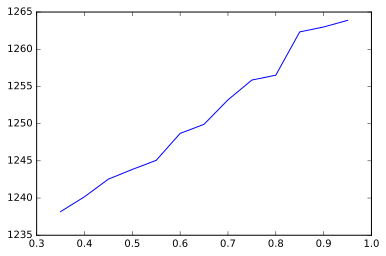

In [344]:
# run Sparse Random Projection

score = []
Eps = (arange(0.05, 1, 0.05)).tolist()
length = len(Eps)
i = 0
while i < length-1:  
    try:
        srp = random_projection.SparseRandomProjection(n_components='auto', eps = Eps[i], dense_output=True,random_state=4487)
        trainXnsrp = srp.fit_transform(trainXn) 
        testXnsrp = srp.transform(testXn)

        trainYlog = log(trainY)

        ols = linear_model.LinearRegression(normalize=True)
        ols.fit(trainXnsrp, trainYlog)

        trainYlogpred = ols.predict(trainXnsrp)
        trainYpred = exp(trainYlogpred)

        # calculate MAE in original space
        MAE = metrics.mean_absolute_error(trainY, trainYpred)
        score.append(MAE)
                
    except ValueError:
        print "Oops! ",Eps[i], "is not a proper value for eps" 
        Eps.remove(Eps[i])
        i -= 1
        
    except IndexError:
        break

    i += 1
        
score = array(score)
plt.plot(Eps, score)

To find a suitable number of reduced dimension, the above graph is drawn. For the same reason in part a, we also choose ϵ = 0.8.

In [9]:
srp = random_projection.SparseRandomProjection(n_components='auto', eps = 0.8, dense_output=True,random_state=4487)
trainXnsrp = srp.fit_transform(trainXn) 
testXnsrp = srp.transform(testXn)
trainXl = trainXnsrp
testXl = testXnsrp

In [10]:
print shape(trainXnsrp)

(188318L, 325L)


To fit for the final weight combination step, we again split the training data to get a validation set.

In [11]:
# randomly split data into 50% train and 50% validation set
trainXs, valX, trainYs, valY = cross_validation.train_test_split(trainXl, trainY, 
                                                                 train_size=0.5, test_size=0.5, random_state=4487)

### 3.Train Models to be Combined

As the general performan and number of dimensions in the isotropic rpresentation does not differ too much to that in the representation of "one-hot" representation, we then train the same set of models for future combination. 

### 4. Training Process

We skip OLS to train RR directly because when the regularization term goes to zero, it is the same as OLS.

### a. RR

In [12]:
trainYlog = log(trainYs)

#trainXm = trainXn force 0
#testXm = testXn

# alpha values to try
alphas = logspace(-1,3,30)

# train RR with cross-validation
rr = linear_model.RidgeCV(alphas=alphas, cv=5)
rr.fit(trainXs, trainYlog)

print rr.alpha_

trainYlogpred = rr.predict(trainXs)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYlog, trainYlogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainYs, trainYpred)

print "MAE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYlogpred = rr.predict(testXl)
testYpred = exp(testYlogpred)

write_csv_allstate("allstate_rr.csv", testID, testYpred)

16.1026202756
MAE_log = 0.443530954856
MAE     = 1258.66235768


In [14]:
print rr.coef_

[ 0.12027251 -0.17606542  0.09884547 -0.09854711 -0.08198027 -0.18812279
  0.03162084  0.03648329  0.0343149  -0.01824031 -0.03040137  0.06290909
 -0.03873807  0.04797593  0.11061339  0.12855892  0.02172656 -0.20332298
  0.01287069  0.1418476  -0.12478458 -0.00478938  0.13957944 -0.13677437
 -0.09399089 -0.05479696  0.15635416  0.04336371 -0.04106867  0.10602005
 -0.05497965  0.07844897  0.23417098 -0.08593433  0.0764756   0.11864768
  0.02036685 -0.15556441  0.04824266 -0.0125594  -0.02402937  0.06509838
 -0.11441495  0.0176041   0.19740284  0.21790124  0.10829614  0.03361529
  0.15987127 -0.05628154 -0.06636441  0.02048611 -0.0105479  -0.02106736
  0.11576328 -0.06400627 -0.04964232  0.00320997  0.05341185  0.04269481
  0.14704259 -0.05268638 -0.13691535  0.07952178  0.03433382 -0.15951145
 -0.10589252  0.09414169 -0.20707457  0.06755774  0.15952883 -0.10606323
 -0.02649685 -0.06117064  0.12441185 -0.11085238  0.11809826 -0.10526394
 -0.0177859   0.11933361  0.08391896  0.14956511 -0

### b. ElasticNet

In [34]:
# setup the parameters and run CV
en = linear_model.ElasticNet(fit_intercept=True, normalize=False, precompute=True, max_iter=1000,tol=0.005, 
                                     warm_start=False, positive=False, random_state=4487, selection='random')
paramgrid = {'alpha': logspace(-2,4,6), 'l1_ratio':arange(0,1.1,0.1)}
modelen = grid_search.GridSearchCV(en, paramgrid, cv=5)
modelen.fit(trainXs, trainYlog)


trainYlogpred = modelen.predict(trainXs)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYlog, trainYlogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainYs, trainYpred)

print "MAE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYlogpred = modelen.predict(testXl)
testYpred = exp(testYlogpred)

write_csv_allstate("allstate_en.csv", testID, testYpred)
print 'MAE_log = 0.447610185324'
print 'MAE     = 1267.94315702'

MAE_log = 0.447610185324
MAE     = 1267.94315702


In [14]:
# store the current job
joblib.dump(modelen, 'modelen.pkl')  

['modelen.pkl',
 'modelen.pkl_01.npy',
 'modelen.pkl_02.npy',
 'modelen.pkl_03.npy',
 'modelen.pkl_04.npy',
 'modelen.pkl_05.npy',
 'modelen.pkl_06.npy',
 'modelen.pkl_07.npy',
 'modelen.pkl_08.npy',
 'modelen.pkl_09.npy',
 'modelen.pkl_10.npy',
 'modelen.pkl_11.npy',
 'modelen.pkl_12.npy',
 'modelen.pkl_13.npy',
 'modelen.pkl_14.npy',
 'modelen.pkl_15.npy',
 'modelen.pkl_16.npy',
 'modelen.pkl_17.npy',
 'modelen.pkl_18.npy',
 'modelen.pkl_19.npy',
 'modelen.pkl_20.npy',
 'modelen.pkl_21.npy',
 'modelen.pkl_22.npy',
 'modelen.pkl_23.npy',
 'modelen.pkl_24.npy',
 'modelen.pkl_25.npy',
 'modelen.pkl_26.npy',
 'modelen.pkl_27.npy',
 'modelen.pkl_28.npy',
 'modelen.pkl_29.npy',
 'modelen.pkl_30.npy',
 'modelen.pkl_31.npy',
 'modelen.pkl_32.npy',
 'modelen.pkl_33.npy',
 'modelen.pkl_34.npy',
 'modelen.pkl_35.npy',
 'modelen.pkl_36.npy',
 'modelen.pkl_37.npy',
 'modelen.pkl_38.npy',
 'modelen.pkl_39.npy',
 'modelen.pkl_40.npy',
 'modelen.pkl_41.npy',
 'modelen.pkl_42.npy',
 'modelen.pkl_43.n

In [13]:
modelen = joblib.load('modelen.pkl') 

### c. Stochastic Gradient Descent

### (1)  SGD Regressor with huber loss

In [35]:
# setup the parameters and run CV
# Use 5 epochs
sgd_huber = linear_model.SGDRegressor(loss='huber', penalty='l2', n_iter=5, shuffle=True, 
                          verbose=0, random_state=4487, learning_rate='invscaling', 
                          eta0=0.01, power_t=0.25, warm_start=False)

paramgrid = {'alpha': logspace(-2,3,5), 'l1_ratio':arange(0,1.1,0.1), 'epsilon': arange(0.05, 0.5, 0.05)}
modelhuber = grid_search.GridSearchCV(sgd_huber, paramgrid, cv=5)
modelhuber.fit(trainXs, trainYlog)


trainYlogpred = modelhuber.predict(trainXs)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYlog, trainYlogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainYs, trainYpred)

print "MAE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYlogpred = modelhuber.predict(testXl)
testYpred = exp(testYlogpred)

write_csv_allstate("allstate_huber.csv", testID, testYpred)

MAE_log = 0.469585305243
MAE     = 1322.6618739


### (2) SGD Regressor with epsilon insensitive loss

In [36]:
# setup the parameters and run CV
# Use 5 epochs
sgd_svr = linear_model.SGDRegressor(loss='epsilon_insensitive', penalty='l2', n_iter=5, shuffle=True, 
                          verbose=0, random_state=4487, learning_rate='invscaling', 
                          eta0=0.01, power_t=0.25, warm_start=False)

paramgrid = {'alpha': logspace(-2,3,5), 'l1_ratio':arange(0,1.1,0.1), 'epsilon': arange(0.05, 0.5, 0.05)}
modelsvr = grid_search.GridSearchCV(sgd_svr, paramgrid, cv=5)
modelsvr.fit(trainXs, trainYlog)


trainYlogpred = modelsvr.predict(trainXs)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYlog, trainYlogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainYs, trainYpred)

print "MAE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYlogpred = modelsvr.predict(testXl)
testYpred = exp(testYlogpred)

write_csv_allstate("allstate_svr.csv", testID, testYpred)

MAE_log = 0.470207560098
MAE     = 1344.22984445


In [26]:
# store the current job
joblib.dump(modelsvr, 'modelsvr.pkl') 
joblib.dump(modelhuber, 'modelhuber.pkl') 

['modelhuber.pkl',
 'modelhuber.pkl_01.npy',
 'modelhuber.pkl_02.npy',
 'modelhuber.pkl_03.npy',
 'modelhuber.pkl_04.npy',
 'modelhuber.pkl_05.npy',
 'modelhuber.pkl_06.npy',
 'modelhuber.pkl_07.npy',
 'modelhuber.pkl_08.npy',
 'modelhuber.pkl_09.npy',
 'modelhuber.pkl_10.npy',
 'modelhuber.pkl_11.npy',
 'modelhuber.pkl_12.npy',
 'modelhuber.pkl_13.npy',
 'modelhuber.pkl_14.npy',
 'modelhuber.pkl_15.npy',
 'modelhuber.pkl_16.npy',
 'modelhuber.pkl_17.npy',
 'modelhuber.pkl_18.npy',
 'modelhuber.pkl_19.npy',
 'modelhuber.pkl_20.npy',
 'modelhuber.pkl_21.npy',
 'modelhuber.pkl_22.npy',
 'modelhuber.pkl_23.npy',
 'modelhuber.pkl_24.npy',
 'modelhuber.pkl_25.npy',
 'modelhuber.pkl_26.npy',
 'modelhuber.pkl_27.npy',
 'modelhuber.pkl_28.npy',
 'modelhuber.pkl_29.npy',
 'modelhuber.pkl_30.npy',
 'modelhuber.pkl_31.npy',
 'modelhuber.pkl_32.npy',
 'modelhuber.pkl_33.npy',
 'modelhuber.pkl_34.npy',
 'modelhuber.pkl_35.npy',
 'modelhuber.pkl_36.npy',
 'modelhuber.pkl_37.npy',
 'modelhuber.pkl_38

In [14]:
modelsvr = joblib.load('modelsvr.pkl') 
modelhuber = joblib.load('modelhuber.pkl') 

In [17]:
# store the current job
joblib.dump(modelrf, 'modelrf.pkl')

['modelrf.pkl',
 'modelrf.pkl_01.npy',
 'modelrf.pkl_02.npy',
 'modelrf.pkl_03.npy',
 'modelrf.pkl_04.npy',
 'modelrf.pkl_05.npy',
 'modelrf.pkl_06.npy',
 'modelrf.pkl_07.npy',
 'modelrf.pkl_08.npy',
 'modelrf.pkl_09.npy',
 'modelrf.pkl_10.npy',
 'modelrf.pkl_11.npy',
 'modelrf.pkl_12.npy',
 'modelrf.pkl_13.npy',
 'modelrf.pkl_14.npy',
 'modelrf.pkl_15.npy',
 'modelrf.pkl_16.npy',
 'modelrf.pkl_17.npy',
 'modelrf.pkl_18.npy',
 'modelrf.pkl_19.npy',
 'modelrf.pkl_20.npy',
 'modelrf.pkl_21.npy',
 'modelrf.pkl_22.npy',
 'modelrf.pkl_23.npy',
 'modelrf.pkl_24.npy',
 'modelrf.pkl_25.npy',
 'modelrf.pkl_26.npy',
 'modelrf.pkl_27.npy',
 'modelrf.pkl_28.npy',
 'modelrf.pkl_29.npy',
 'modelrf.pkl_30.npy',
 'modelrf.pkl_31.npy',
 'modelrf.pkl_32.npy',
 'modelrf.pkl_33.npy',
 'modelrf.pkl_34.npy',
 'modelrf.pkl_35.npy',
 'modelrf.pkl_36.npy',
 'modelrf.pkl_37.npy',
 'modelrf.pkl_38.npy',
 'modelrf.pkl_39.npy',
 'modelrf.pkl_40.npy',
 'modelrf.pkl_41.npy',
 'modelrf.pkl_42.npy',
 'modelrf.pkl_43.n

### (d) SVR with kernels

In this section, we go similar procedures in those in part a, which are retriving subset of the training set for parameter selection and train the models with the selected parameter by fitting all data in our training set.  

In [15]:
# randomly select subset of training data to speed up cross-validation
Xtrain, Xval, Ytrain, Yval = cross_validation.train_test_split(trainXs, trainYs, 
                                                                 train_size=0.15, test_size=0.85, random_state=4487)

In [15]:
modelrf = joblib.load('modelrf.pkl') 

In [17]:
Ytrainlog = log(Ytrain)
Yvallog = log(Yval)

ols = linear_model.LinearRegression(normalize=True)
ols.fit(Xtrain, Ytrainlog)

trainYlogpred = ols.predict(Xtrain)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog1 = metrics.mean_absolute_error(Ytrainlog, trainYlogpred)

# calculate MAE in original space
MAE1 = metrics.mean_absolute_error(Ytrain, trainYpred)

print "MAE_log = " + str(MAElog1)
print "MAE     = " + str(MAE1)

# predict on test set, and save Kaggle submission file
valYlogpred = ols.predict(Xval)
valYpred = exp(valYlogpred)

# calculate MAE in log-output space
MAElog2 = metrics.mean_absolute_error(Yvallog, valYlogpred)

# calculate MAE in original space
MAE2 = metrics.mean_absolute_error(Yval, valYpred)

print "MAE_log = " + str(MAElog2)
print "MAE     = " + str(MAE2)

MAE_log = 0.440364098144
MAE     = 1252.28111385
MAE_log = 0.449151164519
MAE     = 1282.02768791


In [40]:
# parameters to try
params = {'C': logspace(-4,2,5),
          'degree': arange(2,8,1),
          'epsilon': logspace(0,3,4)}

# do cross-validation with grid_search module.
svrpoly = grid_search.GridSearchCV(svm.SVR(kernel='poly',coef0=0.1), # estimator
                                   params, # parameters to try
                                   scoring='mean_squared_error', # score function
                                   cv=5,
                                   n_jobs=-1,
                                   verbose=0) 
svrpoly.fit(Xtrain, Ytrainlog)

trainYlogpred = svrpoly.predict(Xtrain)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(Ytrainlog, trainYlogpred)
# calculate MAE in original space
MAE = metrics.mean_absolute_error(Ytrain, trainYpred)

print "MAE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

param = svrpoly.best_params_

print "best params:"
print param


MAE_log = 0.460504757844
MAE     = 1298.43948305
best params:
{'epsilon': 1.0, 'C': 3.1622776601683791, 'degree': 2}


In [26]:
modelpoly = svm.SVR(C=param['C'], kernel='poly', coef0=0.1, degree=param['degree'], epsilon=param['epsilon'])
modelpoly.fit(trainXs, trainYlog)

trainYlogpred = modelpoly.predict(trainXs)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYlog, trainYlogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainYs, trainYpred)

print "MAE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYlogpred = modelpoly.predict(testXl)
testYpred = exp(testYlogpred)

write_csv_allstate("allstate_svrpoly.csv", testID, testYpred)

MAE_log = 0.443064540276
MAE     = 1237.25302733


In [20]:
# store the current job
joblib.dump(modelpoly, 'modelpoly.pkl')

['modelpoly.pkl',
 'modelpoly.pkl_01.npy',
 'modelpoly.pkl_02.npy',
 'modelpoly.pkl_03.npy',
 'modelpoly.pkl_04.npy',
 'modelpoly.pkl_05.npy',
 'modelpoly.pkl_06.npy',
 'modelpoly.pkl_07.npy',
 'modelpoly.pkl_08.npy',
 'modelpoly.pkl_09.npy',
 'modelpoly.pkl_10.npy']

In [16]:
modelpoly = joblib.load('modelpoly.pkl') 

In [24]:
# parameters to try
# parameters to try
params = {'C': logspace(-4,2,5),
          'gamma': logspace(-4,2,5),
          'epsilon': logspace(0,3,4)}

# do cross-validation with grid_search module.
svrrbf = grid_search.GridSearchCV(svm.SVR(kernel='rbf'), # estimator
                                   params, # parameters to try
                                   scoring='mean_squared_error', # score function
                                   cv=5, 
                                   n_jobs=-1,
                                   verbose=0)
svrrbf.fit(Xtrain, Ytrainlog)

trainYlogpred = svrrbf.predict(Xtrain)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(Ytrainlog, trainYlogpred)
# calculate MAE in original space
MAE = metrics.mean_absolute_error(Ytrain, trainYpred)

print "MAE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

param = svrrbf.best_params_

print "best params:"
print param


MAE_log = 0.462100499287
MAE     = 1300.33783064
best params:
{'epsilon': 1.0, 'C': 100.0, 'gamma': 0.0001}


In [38]:
modelrbf = svm.SVR(C=param['C'], kernel='rbf', gamma=param['gamma'], epsilon=param['epsilon'])
modelrbf.fit(trainXs, trainYlog)

trainYlogpred = modelrbf.predict(trainXs)
trainYpred = exp(trainYlogpred)

# calculate MAE in log-output space
MAElog = metrics.mean_absolute_error(trainYlog, trainYlogpred)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainYs, trainYpred)

print "MAE_log = " + str(MAElog)
print "MAE     = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYlogpred = modelrbf.predict(testXl)
testYpred = exp(testYlogpred)

write_csv_allstate("allstate_svrrbf.csv", testID, testYpred)

MSE_log = 0.449350127507
MAE     = 1257.07003079


In [39]:
# store the current job
joblib.dump(modelrbf, 'modelrbf.pkl')

['modelrbf.pkl',
 'modelrbf.pkl_01.npy',
 'modelrbf.pkl_02.npy',
 'modelrbf.pkl_03.npy',
 'modelrbf.pkl_04.npy',
 'modelrbf.pkl_05.npy',
 'modelrbf.pkl_06.npy',
 'modelrbf.pkl_07.npy',
 'modelrbf.pkl_08.npy',
 'modelrbf.pkl_09.npy',
 'modelrbf.pkl_10.npy']

In [17]:
modelrbf = joblib.load('modelrbf.pkl') 

# 4. Weight assignment and model combination

As all of the selected models have been trained, we are now ready to determine the weights. Suppose there are $n$ models to be combined, and $m$ points in the validation set. Since the purpose of assigning weights to the models is to improve the overall error, we intuitively convert the problem to a optimization problem to minimize MSE and is formulated as follow:
$$\underset{w}{\text{min}} \underset{j}{\sum}(\underset{i}{\sum} w_i \hat{y_j}^{(i)} - y_j)^2,\text{ } 0 \leq i \leq n-1,\text{ } 0 \leq j \leq m-1,$$, where $w$ is the vector of the weights for each mode, $\hat{y}^{(i)}$ is the predicted value vector by the $i-th$ model, $y$ is the vector of the true values, and the subscript $j$ indicates the $j-th$ data point. We didn't choose MAE since we want to enlarge the difference between the predicted value by the combined regression model.

To get the optimal solution, we consider to take partial derivatives and let them be zeros so to find the critical point. So we then have the following system of equations:
$$ \frac{\partial}{\partial w_k} \underset{j}{\sum}(\underset{i}{\sum} w_i \hat{y_j}^{(i)} - y_j)^2 = 0,\text{ } 0 \leq i \leq n-1, \text{ }0 \leq j \leq m-1,\text{ } 0 \leq k \leq m-1  $$
and it can be simplified to 
$$ A w = b, $$ where $A_{ki} = \underset{j}{\sum}\hat{y_j}^{(k)}\hat{y_j}^{(i)}$ and $b_k = \underset{j}{\sum}\hat{y_j}^{(k)}y_j.$
So we can solve the equation and find $w$.

In our case, the critical point is also the point that gives the absolute minimum MSE. Below is the function for calculating the weights.


In [22]:
def comp_weight(models, valX, valY):#, C0): # C0 is the hyperparameter for penalty 
    #C = 10**C0
    C = [0]
    n = len(models)
    PredY = []
    b = []
    weight = []
    err = []
       
    for model in models:
        predY = exp(model.predict(valX))
        PredY.append(predY) # store predicion on the validation set by each model
        b_temp = dot(predY, transpose(valY)) 
        b.append(b_temp)

    b = array(b)
    
    for c in C:
        A = []

        for k in arange(n):
            a = []
            for i in arange(n):
                a_temp = dot(PredY[k], transpose(PredY[i]))
                if i == k:
                    a_temp += c 
                a.append(a_temp)
            A.append(a)

        A = array(A)

        weights = transpose(dot(linalg.inv(A),transpose(b)))
        weight.append(weights.copy())
        #weights[weights<0]=0  # force entries to be larger than zero to make the calculation of weights meaningful
        
        for i in arange(n):
            #if weights[i]!=0: # Avoid extra computation when a weight for some model is zero
            predY += weights[i]*PredY[i]
        
        predY = predY/sum(weights)

        #MAE = metrics.mean_absolute_error(valY, predY)
        #err.append(MAE)

    #err = array(err)
    #plt.plot(C0[1:], err[1:])
    #plt.ylim([1200,2500])
    #plt.xlim([C0[1], C0[-1]])
    
    return weight
        

Then we define the function to combine the models in a linear sense by multiplying the value predicted by each model for the test data with its corresponding weight and add them together.

In [19]:
def pred_by_new_model(X, models, weight):
    predY = zeros(len(X)) # initialize
    
    for i in arange(len(models)):
        if weight[i]!=0: # Avoid extra computation when a weight for some model is zero
            Ypred = exp(models[i].predict(X))
            predY += weight[i]*Ypred
        print Ypred
        
    predY = predY/sum(weight) # normalization
    
    return predY

Now let's call the functions to calculate weights and combine our selected models, which are Ridge Regression, Elastic Network, linear Robust Regression, linear SVR, and kernel based SVR models.

We still seperate the process into two parts:  one for "One-hot" representation and another for isotropic representation.

## a. "One-hot" representation

In [ ]:
from sklearn.externals import joblib
rrs = joblib.load('rrs.pkl')
modelen = joblib.load('ens.pkl') 
modelhuber = joblib.load('huber.pkl') 
modelsvr = joblib.load('svr.pkl') 
modelrf = joblib.load('rf.pkl') 
modelpoly = joblib.load('svrpoly.pkl') 
modelrbf = joblib.load('rbf.pkl') 

In [55]:
models = [rrs, modelen, modelhuber, modelsvr, modelpoly, modelrbf]

weights = comp_weight(models, valX, valY)#,linspace(2,12,11))

Below shows the obtained weight.

In [56]:
print [weights[i]/sum(weights[i]) for i in arange(len(weights))]

[array([ 0.78145849, -0.51863682,  0.0402034 , -0.09113972,  0.13311732,
        1.65138607, -0.99638875])]


It can be observed that the heaviest weights occur in the Ridge Regression model and plynomial kernel based SVR.

In [57]:
weight = weights[0] 

In [61]:
trainYpred = pred_by_new_model(trainXI, models, weight)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainY, trainYpred)

print "MAE     = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYpred =pred_by_new_model(testXI, models, weight)

write_csv_allstate("allstate_final.csv", testID, testYpred)

[ 1460.68695533  1613.31714025  4503.94430752 ...,
3755.16665406  2794.70276844  3954.06221419]
[ 1433.29229873  1757.3582856   4458.03282722 ..., 
3586.53909944  2725.5846026   3179.92616511]
[ 1558.84869098  2328.17670345  5257.29562917 ...,  
3325.84636797  2171.60542115  3078.04799653]
[ 1624.0831102   2431.92326857  5410.7015179  ...,  
3550.95701948  2485.89942706  3931.35770999]
[ 1638.81052413  1815.07718036  3802.07414362 ...,  
4208.7699115  2889.57333064  2486.21479727]
[ 1486.70655988  1566.9482089   3515.21894952 ...,  
3508.9468574   2693.00216619  3060.38231183]
[ 1447.67600508  1581.06963235  3811.95531505 ...,  
3644.80469258   2641.79917265  3645.38660869]
MAE     = 1217.31210759
[ 1891.93857243  1185.4437575   7422.16696177 ...,  
2203.37589391  1122.93855345  1984.33184071]
[ 1611.47573932  1318.16290935  9021.42044016 ...,  
2318.54875184   990.73155798  2490.45170131]
[ 1655.03219574   1173.63380479  10245.40994236 ..., 
2084.6567812   1063.05908547   2504.8204444

## b. Isotropic representation

In [24]:
models = [rr, modelen, modelhuber, modelsvr, modelpoly, modelrbf]

weights = comp_weight(models, valX, valY)#,linspace(2,12,11))

Below shows the obtained weight.

In [68]:
print [weights[i]/sum(weights[i]) for i in arange(len(weights))]

[-1.79663772  1.16146785  0.77535336 -0.63772208 -3.44257354  1.49753859]


It can be observed that the heaviest weights again occur in the Ridge Regression model and plynomial kernel based SVR.

In [26]:
weight = weights[0] 

In [27]:

trainYpred = pred_by_new_model(trainXl, models, weight)

# calculate MAE in original space
MAE = metrics.mean_absolute_error(trainY, trainYpred)

print "MAE     = " + str(MAE)

# predict on test set, and save Kaggle submission file
testYpred =pred_by_new_model(testXl, models, weight)

write_csv_allstate("allstate_final.csv", testID, testYpred)

[ 1645.00172224  1690.26640767  4048.02526414 ...,  3773.7542743
  2607.17244255  2245.81257213]
[ 1601.40935593  1670.97878413  4084.12031585 ...,  3725.74416209
  2538.23583516  1722.74929408]
[ 1817.01581738  1604.68071477  4472.750283   ...,  4317.25267244
  2551.57917118  1716.03574731]
[ 2024.81074195  1803.50686199  4483.58501412 ...,  4321.91343771
  2756.89803782  2049.19389722]
[ 2063.33284263  1865.65884576  4010.04590923 ...,  3980.27708619
  3818.63285194  1835.67653419]
[ 1568.815769    1495.2551867   3248.31126342 ...,  3730.82439862
  2510.47583574  1721.76055168]
[ 1588.34917229  1566.13192917  3433.5476787  ...,  3816.29033409
  2561.750499    1935.78193935]
MAE     = 1197.06997146
[  1487.35706098   1462.34195242  11410.96952834 ...,   2124.2251944
   1133.84798844   2901.88916039]
[  1558.71904166   1889.46816339  12549.95330855 ...,   2321.08067401
   1114.50861574   3142.4698409 ]
[  1433.70937776   2207.85478883  10126.27259674 ...,   1579.28492114
   1090.636999

## A short summary for two combined models by two representations:

- After submit the result on Kaggle, we get the best result for ohe feature representation, 1317.98374, which is better than simple one model results.


- The test MAE for Isotropic feature representation is 1246.05351, and it is ever the best. Comparing with results of ohe feature representation, we find it much better, which may mean that Isotropic feature representation is more suitable for this data set.



# 5. Discussion and Conclusion

We use two feature representation methods and try various regression models to do a weighted combination respectively. The result is indeed increase but there may still exist problems in the training process.

- For the orginal transfered dataset, we cannot get a graph from Manifold Embedding since the speed is too slow. We only get a graph of the data after dimension reduction after running 14 hours, but there is no certain struction in the graph. Therefore, if we could perform Manifold Embedding on whole training set and learn more about the data struction, then we may have a better model selection.


- For dimension reduction, one is that using SRP will lose some accuracy. Another possible problem is that we use OLS to see MAE after reduction, but actually we do not really use OLS for model combination. So using OLS to decide the reduction parameter may be not accurate enough.


- During the process to split the training set to speed up, there are three considerations. First is we use sub-train data to run CV and get best parameter but after adding all training data to fit the model, these parameters may not be the best. Second, again we use OLS to see the result which could be not accurate enough. The last one is the split size we choose may not be the best one.


- For weight we get at last, there are some negative values which we think is not significant. But we cannot directly force them to be 0 since once done that, we cannot guarantee that our weight is the best one now.


- For different feature representations, we use same models to combine, which could be not very good since different feature representation means different data structure.


- For Neural Network, we make a trial but the result is very bad since we do not know how many and what kind of hidden layers is the best. Therefore, this still need delicate analysis and further study.


In [44]:
from mpl_toolkits.mplot3d import Axes3D

def plot_manifolds(X, Y, Xrs, titles=None, spwidth=2):
# X - original points
# Y - colors
# Xrs - manifold points (list of manifolds)
    numX = len(Xrs)

    if titles==None:
        titles = []
        for i in range(numX):
            titles.append("manifold" + str(i+1)) 
    
    sx = spwidth
    sy = ceil((numX+1)/float(spwidth))
    
    fig = plt.gcf()
    
    ax = fig.add_subplot(100*sy+10*sx+1, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y, cmap=plt.cm.Spectral)
    ax.view_init(15, -80)
    ax.set_title("Original data")
    
    for i in range(numX):   
        Xr = Xrs[i]
        ax = fig.add_subplot(100*sy+10*sx+i+2)
        ax.scatter(Xr[:, 0], Xr[:, 1], c=Y, cmap=plt.cm.Spectral)
        plt.title(titles[i]); plt.grid()

In [48]:
mds = manifold.MDS(n_components=2, random_state=1234)
Xr = mds.fit_transform(Xtrain)
plot_manifolds(Xtrain, Ytrainlog, [Xr], ["MDS embedding"])

# Reference
Zhang, C., Liu, Y., Wang, J., & Zhu, H. (2015). Reinforced angle-based multicategory support vector machines. $Journal$ $of$ $Computational$ $and$ $Graphical$ $Statistics$, (just-accepted), 00-00.
